## Evaluate Hawkes Process Model
Noam Siegel, Ben Gurion University

In [18]:
import gpytorch
import torch
import yaml
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from msc.canine_db_utils import get_record_start, get_onsets, get_ipp_training_data
from msc.models import InteractingPointProcessGPModel, HawkesProcessGP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
dog_num = 3
model_version = '0.1.8'
hparams_fpath = fr"C:\Users\noam\Repositories\noamsgl\msc\results\lightning_logs\prior\ipp\ipp_prior\{model_version}\hparams.yaml"

with open(hparams_fpath, 'r') as stream:
    hparams = yaml.safe_load(stream)

train_x, train_y, inducing_points= get_ipp_training_data(dog_num, hparams)
test_x = train_x[:10000]
hparams

{'random_seed': 42,
 'learning_rate': 0.01,
 'n_epochs': 800,
 'patience': 6,
 'batch_size': 2048,
 'inducing_time_step': 14400,
 'cholesky_jitter_double': 0.1,
 'real_time_step': 600,
 'num_cycles': 0,
 'version': '0.1.8',
 'enable_progress_bar': True,
 'fast_dev_run': False,
 'graphic_verbose': True}

In [20]:
state_dict = torch.load(fr"C:\Users\noam\Repositories\noamsgl\msc\results\lightning_logs\prior\ipp\ipp_prior\{model_version}\checkpoints\gp_ipp_state_dict.pth")
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
model = HawkesProcessGP(train_x, likelihood, inducing_points, num_cycles=hparams['num_cycles'])

In [21]:
model.state_dict()

OrderedDict([('variational_strategy.inducing_points',
              tensor([[0.0000e+00],
                      [1.0000e+00],
                      [2.0000e+00],
                      ...,
                      [2.6970e+03],
                      [2.6980e+03],
                      [2.6990e+03]])),
             ('variational_strategy.variational_params_initialized',
              tensor(0)),
             ('variational_strategy.updated_strategy', tensor(True)),
             ('variational_strategy._variational_distribution.variational_mean',
              tensor([0., 0., 0.,  ..., 0., 0., 0.])),
             ('variational_strategy._variational_distribution.chol_variational_covar',
              tensor([[1., 0., 0.,  ..., 0., 0., 0.],
                      [0., 1., 0.,  ..., 0., 0., 0.],
                      [0., 0., 1.,  ..., 0., 0., 0.],
                      ...,
                      [0., 0., 0.,  ..., 1., 0., 0.],
                      [0., 0., 0.,  ..., 0., 1., 0.],
               

Text(0.5, 1.0, 'Prior')

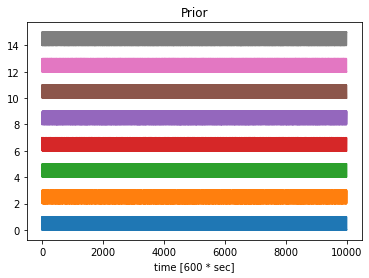

In [22]:
# plot prior samples
prior_distribution = model.likelihood(model(test_x))
n_draws = 8
for i in range(n_draws):
    plt.plot(test_x, (prior_distribution.sample() + 2 * i))
plt.xlabel(f"time [{hparams['real_time_step']} * sec]")
plt.title('Prior')

In [23]:
model.load_state_dict(state_dict)

<All keys matched successfully>

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(


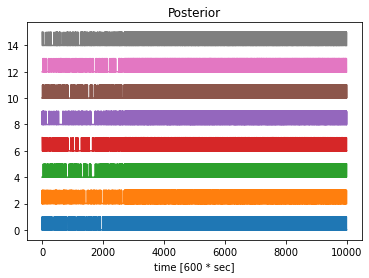

In [24]:
with gpytorch.settings.cholesky_jitter(double=hparams['cholesky_jitter_double']):
    # plot posterior samples
    posterior_distribution = model.likelihood(model(test_x))
    n_draws = 8
    for i in range(n_draws):
        plt.plot(test_x, (posterior_distribution.sample() + 2 * i))
    plt.xlabel(f"time [{hparams['real_time_step']} * sec]")
    plt.title('Posterior')

## Get inter-seizure intervals
In this section we will check the posterior distribution.
We expect the mean and variance of the inter-seizure intervals to fluctuate around the observed values.

### Observation intervals

In [25]:
obs_intervals = train_y.nonzero().diff(dim=0).squeeze().double()

In [26]:
stats.describe(obs_intervals)

DescribeResult(nobs=44, minmax=(16.0, 34061.0), mean=1426.5227272727273, variance=27886033.604122624, skewness=5.5714936849082894, kurtosis=31.738722462165498)

### Draw posterior predictive interval samples

In [ ]:
n_samples = 100
with gpytorch.settings.cholesky_jitter(double=hparams['cholesky_jitter_double']):
    samples = likelihood(model(test_x)).sample((n_samples,))

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(


In [ ]:
samples.size()

In [ ]:
intervals = [samples[i].nonzero().diff(dim=0).squeeze().double() for i in range(len(samples))]

### Plot test statistics

In [ ]:
intervals_means = [torch.mean(inters).item() for inters in intervals]
plt.hist(intervals_means, bins=20, label='posterior samples')
plt.vlines(torch.mean(obs_intervals), 0, 100, colors='r', label='observation')
plt.legend(loc = 'upper left')
plt.xlabel(f"mean interval length [{hparams['real_time_step']} * sec]")
plt.title('mean')
# place a text box with the p_value in the upper right in axes coords
p_value = len([interv_mean for interv_mean in intervals_means if interv_mean < torch.mean(obs_intervals)])/len(intervals_means)
ax = plt.gca()
textstr = r'$P_{value}=%.2f$' % (p_value)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.75, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left',bbox=props);

In [ ]:
intervals_vars = [torch.var(inters).item() for inters in intervals]
plt.hist(intervals_vars, bins=20, label="posterior samples")
plt.vlines(torch.var(obs_intervals), 0, 100, colors='r', label="observation")
plt.legend(loc = 'upper left')
plt.xlabel(f"variance of interval length [{hparams['real_time_step']} * sec]")
plt.title(f"variance")
# place a text box with the p_value in the upper right in axes coords
p_value = len([interv_var for interv_var in intervals_vars if interv_var < torch.var(obs_intervals)])/len(intervals_vars)
ax = plt.gca()
textstr = r'$P_{value}=%.2f$' % (p_value)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.75, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left',bbox=props);

In [ ]:
plt.scatter(intervals_means, intervals_vars, label="posterior samples")
plt.scatter(torch.mean(obs_intervals), torch.var(obs_intervals), c='r', label="observation")
plt.xlabel(f"mean [{hparams['real_time_step']} * sec]")
plt.ylabel(f"variance [{hparams['real_time_step']} * sec]")
plt.legend()
plt.title('intervals posterior predictive checks');